In [1]:
# this enable automatic reloading of libraries
%load_ext autoreload
%autoreload 2

# import libraries
import numpy as np
import matplotlib.pyplot as plt
from clib.geolocation_1Dv import *

In [2]:
### création de la source (vitesse de 2.5 m/s)
sources=[]
sources.append(source( 0.e3, 0, v_x = 2.5))
Ns = len(sources)

### création du récepeur (vitesse de 10cm/s)
r=receiver(5.e3, 0, e_x=10.e3, e_dt=0.005, v_x= 0.1)

### initialisation du mapping
pmap = xtmap(c_b=1500., e_t=0.007) 

In [3]:
t_e = np.arange(0.,3600.,2.*60.)
print(t_e)

[   0.  120.  240.  360.  480.  600.  720.  840.  960. 1080. 1200. 1320.
 1440. 1560. 1680. 1800. 1920. 2040. 2160. 2280. 2400. 2520. 2640. 2760.
 2880. 3000. 3120. 3240. 3360. 3480.]


In [4]:
def simu (r, sources, Nmc, t_e, t_drift, pmap, x0=None, new_method=True) : 
    ''' It returns rms and bias on x position for one receiver position'''
    x = np.zeros(Nmc)
    v = np.zeros(Nmc)
    dt = np.zeros(Nmc)
    su = np.zeros (Nmc)
    J = np.zeros(Nmc)
    
    for i in range(Nmc):
            
        _t = []
        for t in t_e : 
            x_r, y_r = r.get_xy(t)
            x_s, y_s = sources[0].get_xy(t)
            rg = np.sqrt((x_r-x_s)**2 + (y_r - y_s)**2)
            _t.append(t + pmap.draw_t(rg))

        r.t_r_tilda = np.array(_t+r.dt).squeeze()
        
        if not new_method : 
            x[i], v[i], dt[i], success, message, res, J[i] = geolocalize_xtmap_1Dv(r, sources, t_e, pmap, \
                                                                             clock_drift=t_drift, \
                                                                            x0 = x0)    
        else : 

            x1, v1, dt1, success1, message1, res1, J1 = geolocalize_xtmap_1Dv(r, sources, t_e, pmap, clock_drift=t_drift, \
                                                        x0 = np.array([sources[0].x_s - (r.t_r_tilda - t_e)[0]*1500.,0.,0.]))
            x2,v2, dt2, success2, message2, res2, J2 = geolocalize_xtmap_1Dv(r, sources, t_e, pmap, clock_drift=t_drift, \
                                                        x0 = np.array([sources[0].x_s + (r.t_r_tilda - t_e)[0]*1500.,0.,0.]))
            if J1 == J2 : 
                x[i], v[i], dt[i], success, message, res, J[i] = np.NaN, np.NaN, np.NaN, np.NaN, np.NaN, np.NaN, np.NaN
            elif J1 < J2 : 
                x[i], v[i], dt[i], success, message, res, J[i] = x1, v1, dt1, success1, message1, res1, J1
            else : 
                x[i], v[i], dt[i], success, message, res, J[i] = x2, v2, dt2, success2, message2, res2, J2

        if success :
            su[i] = 1 
        elif message.find('iterations')!= -1 : 
            su[i] = 0
            
    # rms error on the receiver position
    d_rms = np.sqrt( np.mean( (x[np.where(su==1)] - r.x)**2 ) )
    # biais on the receiver position
    bias_x = x[np.where(su==1)].mean()-r.x
    return (d_rms, bias_x, su)


In [11]:
Nmc = 100
rms, bias, _ = simu (r, sources, Nmc, t_e, False, pmap, x0=None)

In [12]:
rms

3.8110452679810822

In [13]:
rms, bias, _ = simu (r, sources, Nmc, t_e, True, pmap, x0=None)

In [14]:
rms

60.95676998619303

In [12]:
Nmc = 100
rms, bias, _ = simu (r, sources, Nmc, t_e, True, pmap, x0=None)

In [13]:
rms

9.325215463761793

In [ ]:
###########################################################################
########################## GRAPHES RAPPORT ################################
###########################################################################

In [80]:
Nmc=100

In [125]:
dr = np.array([0.001,0.005,0.05,0.5])   # dérives d'horloges
rms=np.zeros(len(dr))

for i in range(len(dr)) : 
    r.draw_clock_drift(dr[i])
    r.v_x = 0.
    r.e_v = 0.01
    rms[i], _, _ = simu (r, sources, Nmc, t_e, True, pmap, x0=None)
    #print(r.dt, rms)

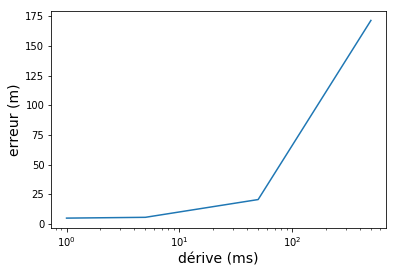

In [126]:
plt.plot(dr*1000., rms)
plt.xlabel("dérive (ms)", fontsize=14)
plt.ylabel("erreur (m)", fontsize=14)
plt.xscale('log')


In [127]:
rms2 = rms

In [128]:
### e_v = 1.e-5, 0.001, 0.005, 0.01, 0.1

print("1e-5 m/s  : ", rms0)
print("1mm/s     : ", rms1)
print("5mm/s     : ", rms4)
print("1cm/s     : ", rms2)
print("10cm/s    : ", rms3)

1e-5 m/s  :  [1.90337226 1.93980036 1.88642101 1.66788882]
1mm/s     :  [1.98711112 3.04568469 6.63421749 2.79045968]
5mm/s     :  [  3.07044905   4.04884967 137.79380337 101.51420705]
1cm/s     :  [  4.93825375   5.60971168  20.57358474 171.41998658]
10cm/s    :  [  3.97109632   3.79896445  19.78646326 112.91213264]


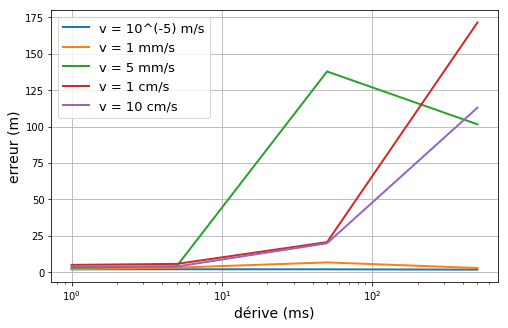

In [129]:
plt.figure(figsize=(8,5))
plt.plot(dr*1000., rms0 , label = 'v = 10^(-5) m/s',linewidth=2.)
plt.plot(dr*1000., rms1, label = 'v = 1 mm/s', linewidth=2.)
plt.plot(dr*1000., rms4, label = 'v = 5 mm/s',linewidth=2.)
plt.plot(dr*1000., rms2, label = 'v = 1 cm/s',linewidth=2.)
plt.plot(dr*1000., rms3, label = 'v = 10 cm/s',linewidth=2.)
plt.xlabel("dérive (ms)", fontsize=14)
plt.ylabel("erreur (m)", fontsize=14)
plt.xscale('log')
plt.grid()
plt.legend(fontsize=13)

In [ ]:
### Rajoouter des valeurs de dérive, par exemple : 1ms, 5ms, 10ms, 25ms, 50ms, 100ms, 250ms, 500ms